In [1]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
import torch
import sklearn


In [2]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import joa_helpers as hlp
import cond_waveunet_dataset as dset
import cond_waveunet_model as cwaveunet
from cond_waveunet_traintest import infer
import importlib
importlib.reload(hlp)
importlib.reload(dset)
importlib.reload(cwaveunet)

2023-11-30 16:10:39.164053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 16:10:52.432019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'cond_waveunet_model' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/cond_waveunet_model.py'>

### Inspect datapoints:

In [3]:
################## LOAD TRAINING PARAMETERS  ##################

# load arguments used for training
args=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--23-13_one-to-many_lr-0.001_bs-8/trainargs.pt")
# args=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--00-20_many-to-many_lr-0.0001_bs-8/trainargs.pt")


In [4]:
################## LOAD DATASET AND CHECK 1 DATAPOINT SAMPLE  ##################

# instantiate a test data set 
args.split="test"
dataset=dset.DatasetReverbTransfer(args)
# get one data sample 
sContent_in, sStyle_in, sTarget_out = dataset[0]

# playback for the data sample
audios=[sContent_in, sStyle_in, sTarget_out]
names=["sContent_in", "sStyle_in", "sTarget_out"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))


sContent_in


sStyle_in


sTarget_out


### Inspect inference with trained models:

In [5]:
################## LOAD MODELS AND TRAINING WEIGHTS  ##################


# load reverb encoder
model_ReverbEncoder=cwaveunet.ReverbEncoder(args)
model_ReverbEncoder.to("cuda")
model_ReverbEncoder.eval()
# check waveunet 
model_waveunet=cwaveunet.waveunet(args)
model_waveunet.to("cuda")
model_waveunet.eval()
# load training results
train_results=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/20-11-2023--10-23_one-to-many_lr-0.0001_bs-8/checkpoint27.pt",map_location=args.device)
# train_results=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--00-20_many-to-many_lr-0.0001_bs-8/checkpoint27.pt",map_location=args.device)

model_waveunet.load_state_dict(train_results["model_waveunet_state_dict"])
model_ReverbEncoder.load_state_dict(train_results["model_reverbenc_state_dict"])


<All keys matched successfully>

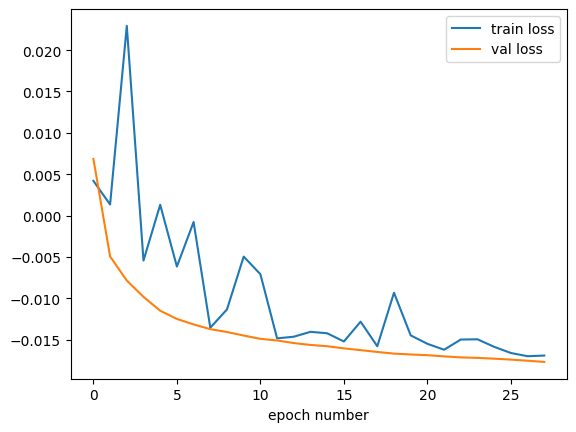

In [6]:
################## PLOT TRAINING LOSS EVOLUTION  ##################

# load and plot the loss evolution 
loss = list(zip(*train_results['loss']))
plt.figure()
plt.plot(loss[1],label="train loss")
plt.plot(loss[0],label="val loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [7]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

def infer(model_reverbenc, model_waveunet, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------
        # get datapoint
        sContent_in = data[0].to(device)
        sStyle_in=data[1].to(device)
        sTarget_gt=data[2].to(device)
        # forward pass - get prediction of the ir
        embedding_gt=model_reverbenc(sStyle_in.unsqueeze(0))
        sTarget_prediction=model_waveunet(sContent_in.unsqueeze(0),embedding_gt)
        return sContent_in, sStyle_in, sTarget_gt, sTarget_prediction

sContent_in, sStyle_in, sTarget_gt, sTarget_prediction=infer(model_ReverbEncoder, model_waveunet, dataset[110], args.device)

RuntimeError: running_mean should contain 49152 elements not 2

sContent_in:


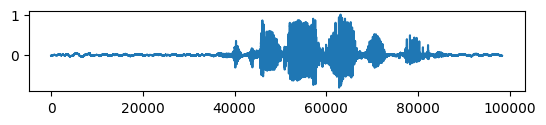

sStyle_in:


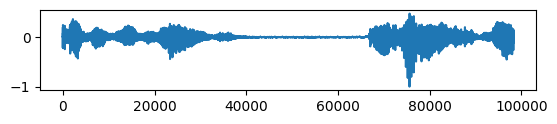

sTarget_gt:


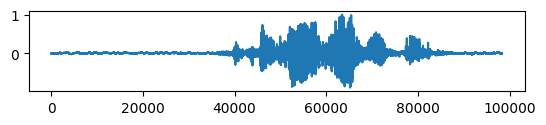

sTarget_prediction:


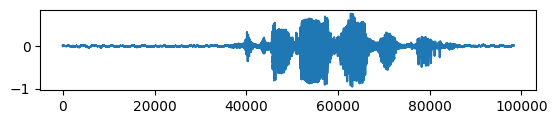

In [ ]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent_in, sStyle_in, sTarget_gt, sTarget_prediction]
names=["sContent_in", "sStyle_in", "sTarget_gt", "sTarget_prediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))


In [ ]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################

emb_arr=np.zeros([len(dataset),512])
rt30_meas_arr=np.zeros([len(dataset),1])
edt_meas_arr=np.zeros([len(dataset),1])
c50_meas_arr=np.zeros([len(dataset),1])
rt60_set_arr=np.zeros([len(dataset),1])
rt60_true_arr=np.zeros([len(dataset),1])
for j,data in enumerate(dataset):
    # get style audio
    sStyle_in=data[1]
    # get style info
    df_Style=dataset.get_info(j,style=True)
    # get style embedding of size 512
    with torch.no_grad():
        embedding=model_ReverbEncoder(sStyle_in.unsqueeze(0).to(args.device))
        emb_arr[j,:]=embedding.cpu().numpy()
    rt30_meas_arr[j]=df_Style["rt30_meas"]
    rt60_set_arr[j]=df_Style["rt60_set"]
    rt60_true_arr[j]=df_Style["rt60_true"]
    edt_meas_arr[j]=df_Style["edt_meas"]
    c50_meas_arr[j]=df_Style["c50_meas"]
    if j==1000:
        break


In [ ]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

indices_subset=range(1000)
# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr[indices_subset,:])
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(PCA(n_components=50).fit_transform(emb_arr[indices_subset,:]))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(emb_arr[indices_subset,:])

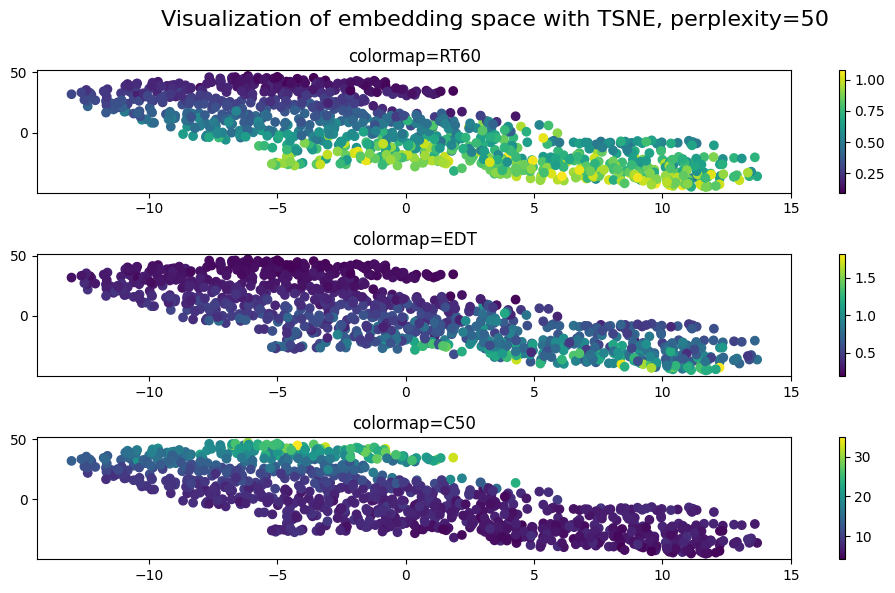

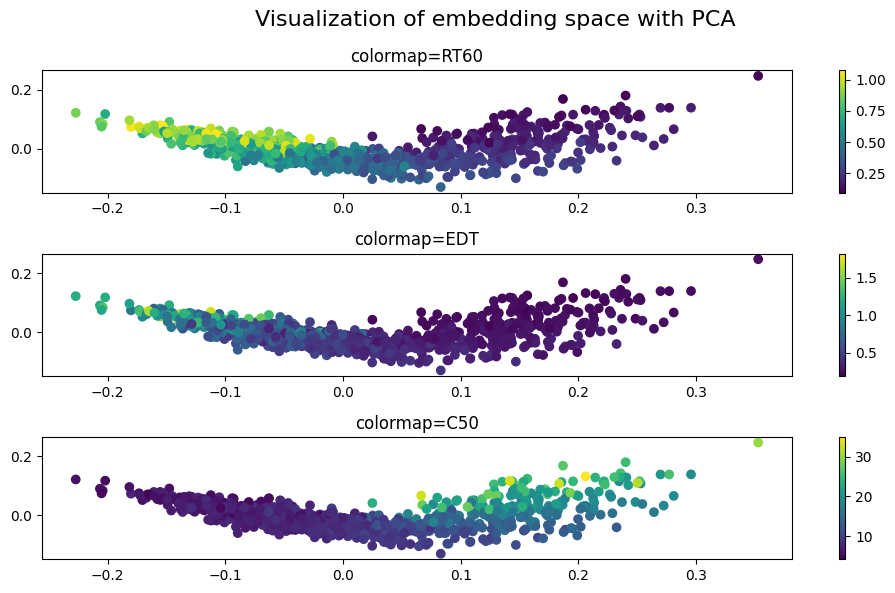

In [ ]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

# plt.figure(figsize=(10,6))
# plt.suptitle('Visualization of embeddings with TSNE, perplexity=50', fontsize=16)
# plt.subplot(2,3,1)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt30_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt30 meas')
# plt.subplot(2,3,2)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 meas')
# plt.subplot(2,3,3)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_set_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 set')
# plt.subplot(2,3,4)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=edt')
# plt.subplot(2,3,5)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=c50')
# cmap = plt.get_cmap('cool')
# plt.set_cmap(cmap)


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()

### Compare training results: one-to-many

In [ ]:
################## COMPARE TRAINING RESULTS  ##################

import speechmetrics 

resultsdir="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/"


for subdir in os.listdir(resultsdir):
    subdir_path = os.path.join(resultsdir, subdir)
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        print(f"Processing traing results: {subdir_path}")
        args=torch.load(pjoin(subdir,"trainargs.pt"))
        # load reverb encoder
        model_ReverbEncoder=cwaveunet.ReverbEncoder(args)
        model_ReverbEncoder.to("cuda")
        model_ReverbEncoder.eval()
        # check waveunet 
        model_waveunet=cwaveunet.waveunet(args)
        model_waveunet.to("cuda")
        model_waveunet.eval()
        # load dataset
        args.split="test"
        dataset=dset.DatasetReverbTransfer(args)
        
        







ModuleNotFoundError: No module named 'speechmetrics'